# HEART DISEASE PREDICTION USING RANDOM FOREST  

> **Objective:**  
Build a `Random Forest` classification model to predict heart disease using the Cleveland Clinical Dataset and evaluate its performance using key ML metrics.

## Introduction  

Machine Learning models — particularly tree-based methods like **Random Forest** — are powerful tools that identify patterns in patient data.

In this project, we will:  

- Perform EDA and preprocessing  
- Train a **Random Forest Classifier**  
- Tune hyperparameters (`n_estimators` and `max_depth`)  
- Evaluate using **Accuracy, Precision, Recall, ROC–AUC**  
- Analyze **Feature Importance**  


### **Importing all the required libraries.**

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")


## **Loading the Dataset**

In [2]:
# Load dataset
df = pd.read_csv("Heart_disease_cleveland_new.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


## Dataset Description  

We use the **Cleveland Heart Disease Dataset**, which contains **303 samples** and **14 attributes**.

### **Features Overview**

| Feature | Description |
|---------|-------------|
| age | Age of the patient |
| sex | Gender (1 = male, 0 = female) |
| cp | Chest pain type |
| trestbps | Resting blood pressure |
| chol | Serum cholesterol (mg/dl) |
| fbs | Fasting blood sugar (> 120 mg/dl) |
| restecg | Resting electrocardiographic results |
| thalach | Maximum heart rate achieved |
| exang | Exercise-induced angina |
| oldpeak | ST depression induced by exercise |
| slope | Slope of the peak exercise ST segment |
| ca | Number of major vessels colored by fluoroscopy |
| thal | Thalassemia |
| target | **1 = disease, 0 = no disease** |


> The **target variable** is binary — perfect for classification!


## Initial Data Exploration  

We inspect:  
- Shape of dataset  
- Missing values  
- Basic statistics  


In [3]:
df['cp'].shape

(303,)

In [4]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [5]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [6]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [8]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,2.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,0.600660,0.663366,1.831683,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,0.956705,0.499120
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,1.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000


In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.nunique()

age          41
sex           2
cp            4
trestbps     50
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            4
thal          3
target        2
dtype: int64

# Exploratory Data Analysis (EDA)

We begin by visualizing the target distribution, gender distribution, how heart disease varies by gender, feature distributions, correlations, and outliers.


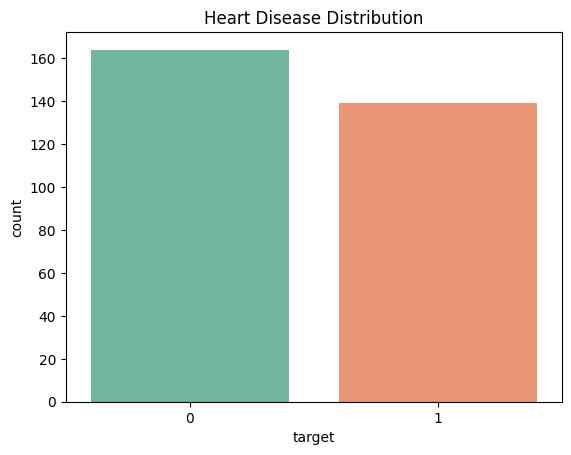

In [11]:
sns.countplot(x=df["target"], palette="Set2")
plt.title("Heart Disease Distribution")
plt.show()


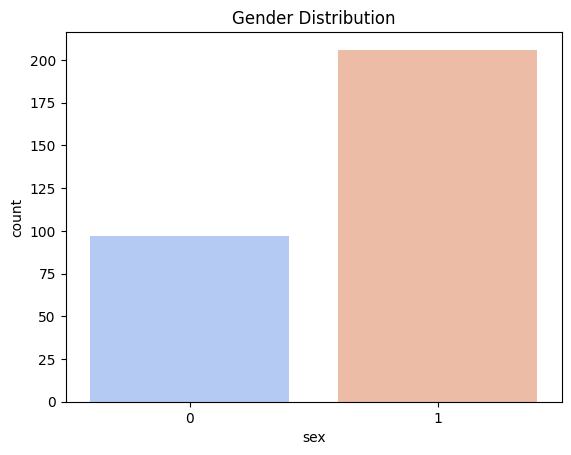

In [12]:

sns.countplot(x=df["sex"], palette="coolwarm")
plt.title("Gender Distribution")
plt.show()


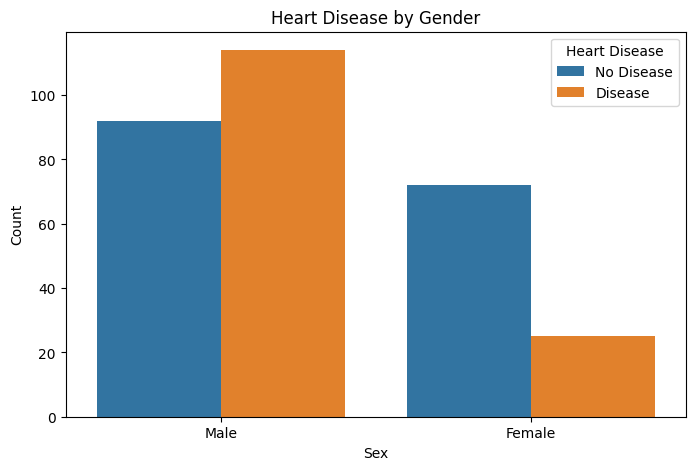

In [13]:
df_plot = df.copy()
df_plot["sex"] = df_plot["sex"].map({0: "Female", 1: "Male"})
df_plot["target"] = df_plot["target"].map({0: "No Disease", 1: "Disease"})

plt.figure(figsize=(8,5))
sns.countplot(data=df_plot, x="sex", hue="target")
plt.title("Heart Disease by Gender")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.legend(title="Heart Disease")
plt.show()

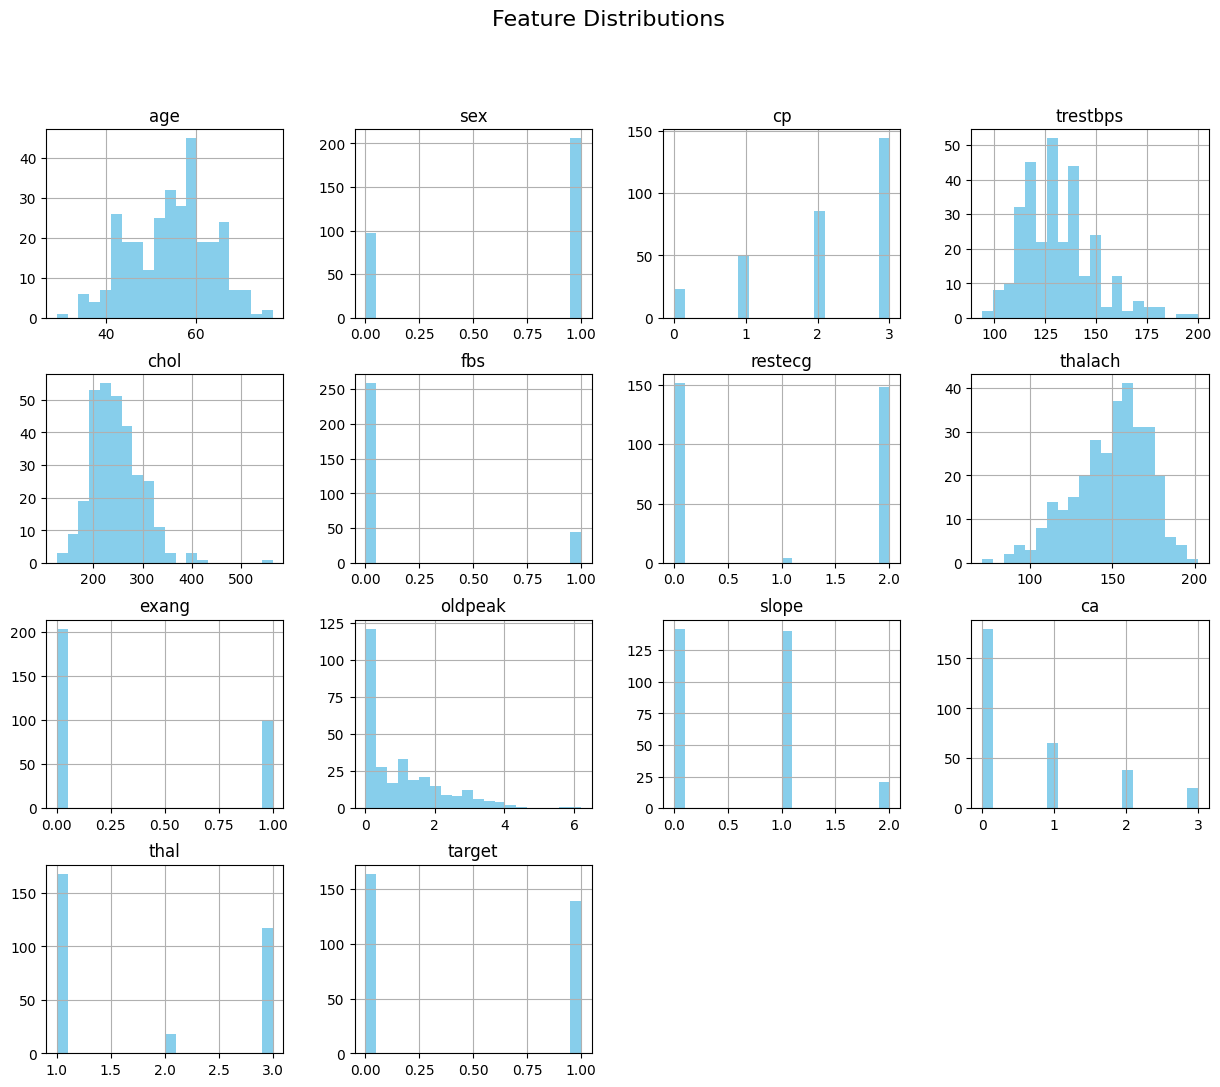

In [14]:
df.hist(figsize=(15, 12), bins=20, color="skyblue")
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()


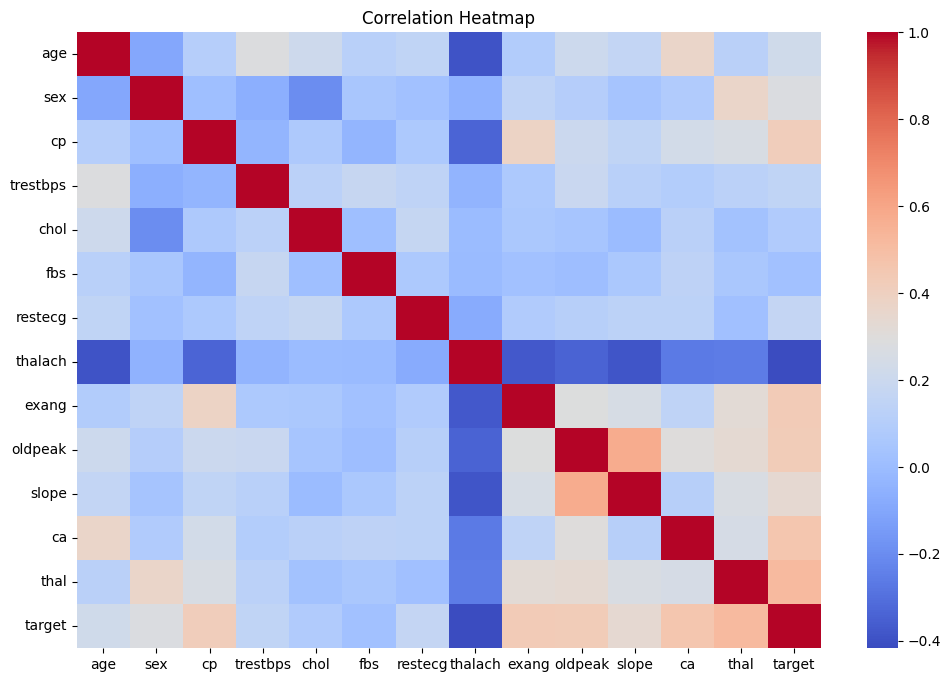

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include="number").corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


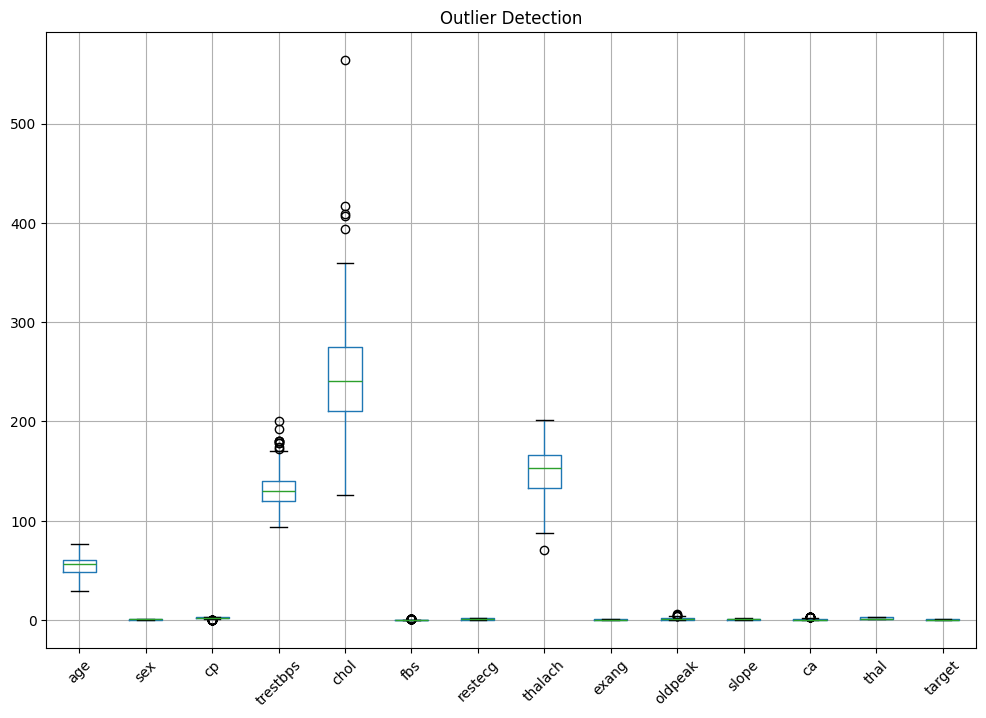

In [16]:
plt.figure(figsize=(12, 8))
df.select_dtypes(include="number").boxplot(rot=45)
plt.title("Outlier Detection")
plt.show()


## Outlier Removal (IQR Method)

Using the Interquartile Range (IQR) method, let us check the outliers.


In [17]:
def get_outliers(df, cols):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Boolean mask for rows that are outliers in ANY column
    mask = ((df[cols] < lower) | (df[cols] > upper)).any(axis=1)

    outliers = df[mask]
    print("\n===== Outliers Detected =====")
    print(outliers)
    print(f"\nTotal Outlier Rows: {outliers.shape[0]}")

    return outliers

numeric_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
outlier_rows = get_outliers(df, numeric_cols)



===== Outliers Detected =====
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
14    52    1   2       172   199    1        0      162      0      0.5   
48    65    0   2       140   417    1        2      157      0      0.8   
83    68    1   2       180   274    1        2      150      1      1.6   
91    62    0   3       160   164    0        2      145      0      6.2   
121   63    0   3       150   407    0        2      154      0      4.0   
123   55    1   3       140   217    0        0      111      1      5.6   
126   56    0   3       200   288    1        2      133      1      4.0   
152   67    0   2       115   564    0        2      160      0      1.6   
172   59    0   3       174   249    0        0      143      1      0.0   
173   62    0   3       140   394    0        2      157      0      1.2   
181   56    0   3       134   409    0        2      150      1      1.9   
183   59    1   0       178   270    0        2      145 

Given the limited size of the dataset, we choose to keep the outliers. Random Forest is relatively insensitive to outliers due to its ensemble structure, making outlier removal unnecessary in this case.

## One-Hot Encoding for Categorical Columns

We convert non-numeric categorical columns into dummy variables so that machine learning models can process them.


In [18]:
categorical_cols = ["sex", "cp", "restecg", "slope", "thal"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
df.head()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,sex_1,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,thal_2,thal_3
0,63,145,233,1,150,0,2.3,0,0,True,False,False,False,False,True,False,True,True,False
1,67,160,286,0,108,1,1.5,3,1,True,False,False,True,False,True,True,False,False,False
2,67,120,229,0,129,1,2.6,2,1,True,False,False,True,False,True,True,False,False,True
3,37,130,250,0,187,0,3.5,0,0,True,False,True,False,False,False,False,True,False,False
4,41,130,204,0,172,0,1.4,0,0,False,True,False,False,False,True,False,False,False,False


In [19]:
df.shape

(303, 19)

## Data Preprocessing  

### Steps performed:
- Handle missing data  
- Split dataset into features and labels  
- Normalize numerical columns using **StandardScaler**  
- Create **train-test split (80–20)**  

> Good preprocessing ensures better model performance.


In [20]:
# Separate features and target
X = df.drop("target", axis=1)
y = df["target"]

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

X_train.shape, X_test.shape


((242, 18), (61, 18))

## Baseline Random Forest Model  

We begin by training a default Random Forest model to observe baseline performance.


In [21]:
rf = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_estimators=200,
    max_depth=12
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

print("Base Accuracy:", accuracy_score(y_test, y_pred))
print("Base Precision:", precision_score(y_test, y_pred))
print("Base Recall:", recall_score(y_test, y_pred))
print("Base ROC-AUC:", roc_auc_score(y_test, y_prob))


Base Accuracy: 0.8688524590163934
Base Precision: 0.9285714285714286
Base Recall: 0.8125
Base ROC-AUC: 0.9321120689655172


## Hyperparameter Tuning  

We tune **two important parameters**:  
- `n_estimators` → number of trees  
- `max_depth` → depth of each tree  

Using **GridSearchCV (5-fold cross-validation)** ensures better generalization.


In [22]:
param_grid = {
    "n_estimators": [150, 200, 300],
    "max_depth": [10, 12, 14],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2"],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight="balanced"),
    param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

print("\nBest Parameters from GridSearch:")
print(grid.best_params_)



Best Parameters from GridSearch:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


## Model Evaluation  

We evaluate performance using:  
- Accuracy  
- Precision  
- Recall  
- ROC–AUC  
- Confusion Matrix  
- Classification Report  


In [23]:
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("\nTuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned Precision:", precision_score(y_test, y_pred_best))
print("Tuned Recall:", recall_score(y_test, y_pred_best))
print("Tuned ROC-AUC:", roc_auc_score(y_test, y_prob_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))



Tuned Accuracy: 0.9016393442622951
Tuned Precision: 0.9333333333333333
Tuned Recall: 0.875
Tuned ROC-AUC: 0.9407327586206896

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



## Confusion Matrix  


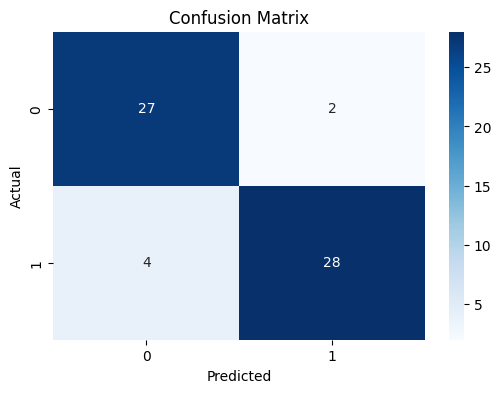

In [24]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## ROC Curve  


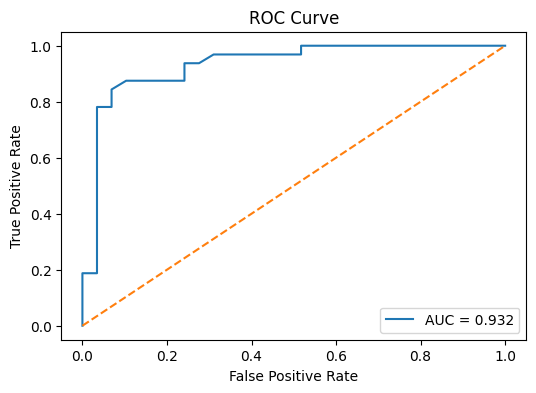

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


## Feature Importance Analysis  

We analyze which input features affect the model’s prediction the most.


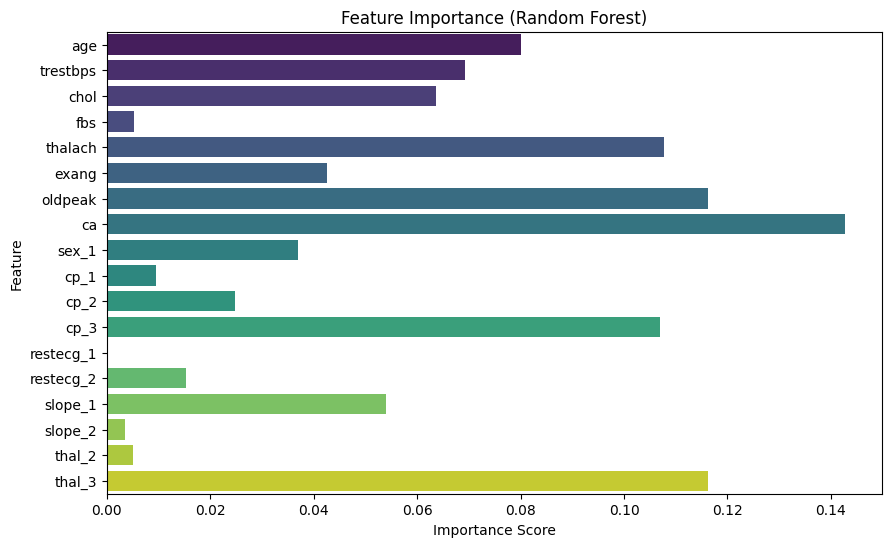

In [26]:
importances = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features, palette="viridis")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


## Conclusion  

> **Random Forest achieved strong performance**  
> using medical attributes to predict heart disease.

### Key Takeaways:
- Hyperparameter tuning improved performance  
- ROC–AUC indicates the model is reliable  
- Important features include:  
  - **cp (chest pain type)**  
  - **thalach**  
  - **oldpeak**  
  - **ca**  
  - **thal**

### Final Statement  
The model is accurate, interpretable, and useful for clinical decision-support applications.

---


## Saving the Trained Model and Scaler

To deploy our Heart Disease Prediction system in a web application (Streamlit),
we need to export the trained **Random Forest model** and the **StandardScaler** used for feature scaling.

These two files will be loaded directly by the Streamlit app to ensure:
- Consistent preprocessing  
- Accurate predictions  
- Reproducible results  

The following code saves the model and scaler as `.pkl` files that can be reused outside this notebook.


In [28]:
scaler = StandardScaler()

In [29]:
import pickle

pickle.dump(best_model, open("best_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))

print("Model and Scaler saved!")


Model and Scaler saved!


In [ ]:
print(list(X.columns))
